In [1]:
#!pip install opencv-python

In [154]:
from tensorflow.keras.applications import inception_v3, VGG19
import tensorflow.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import PIL.Image
from PIL import Image
import scipy

* We won't be training the model so therefore we disable all training-spesific operations
* We build the VGG19 network without its convolutional base. We load the model with pretrained ImageNet weights
* We define a dictionary that maps layer names to a coefficient quintifying how much the layer's activation contributes to the loss we maximize. Note that we'll use harcoded layer names 

In [162]:
K.set_learning_phase(0) 

base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
names = ['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]
model = tf.keras.Model(inputs=base_model.input, outputs=layers)
layer_contributions = {
    'mixed0':0.5,
    'mixed1':1.2,
    'mixed2':1.5,
    'mixed3':1.8,
    'mixed4':0.5,
    'mixed5':0.4
}


In [129]:
base_model = VGG19(weights='imagenet', include_top=False)
names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
layers = [base_model.get_layer(name).output for name in names]
model = tf.keras.Model(inputs=base_model.input, outputs=layers)
layer_contributions = {
    'block1_conv1':0.02,
    'block2_conv1':0.03,
    'block3_conv1':0.005,
    'block4_conv1':0.005
}

* We create a dictionary that maps layer names to layer instances
* We define a scalar variable in which we add the layer contributions 
* We retrieve layers' contributions and outputs
* Adds the L2 norm of the features of a layer to the loss. Specifically, we will maximize a weighted sum of the L2 norm of the activations of a set of high-level layers

In [163]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])    
loss = K.variable(0) 
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss+coeff*K.sum(K.square(activation[:, 2: -2, 2: -2, :]))/scaling

In [164]:
dream = model.input                                 # This holds the generated image - the dream
grads = K.gradients(loss, dream)[0]                 # Computes the gradients of the dream w.r.t to the loss
grads = grads/K.maximum(K.mean(K.abs(grads)), 1e-7) # Normalizes the gradients 
outputs = [loss, grads]
loss_and_grads = K.function([dream], outputs)       # Keras Func to retrieve the loss and grads given an image input

def eval_loss_and_grads(x):
    outs = loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x = x+step*grad_values
    return x

In [165]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [166]:
step = 0.01               # Gradient ascent step size
num_octave = 4            # Number of scales at which to run gradient ascent
octave_scale = 1.4        # Size ratio between scales
iterations = 20           # Number of ascent steps per scale
max_loss = 4              # We will interrupt the gradient ascent process when loss exceeds max_loss to avoid ugly artifacts

base_image_path = '/Users/fi000980702/Desktop/san_diego_scaled.jpg' #  Path to the image you want to shape

img = image.load_img(base_image_path)
width, height = img.size
img_size = (1, width, height, 3)

img = preprocess_image(base_image_path)

#### About deep dream
First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than previous one by a factor 1.4: we start by processing a small image and we increasingly upscale it. Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, at that scale. After each gradient ascent run, we upscale the resulting image by 40%. To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), after each upscaling, we reinject the lost details back into the image


* 1. Prepare a list of shape tuples defining the different scales at which to run gradient ascent
* 2. Reverse the list of shapes so they're in increasing order
* 3. Resize the Numpy array of the image to the smallest scale
* 4. Scale up the dream image and run gradient ascen to alter the dream
* 5. Scale up the smaller version of the original image
* 6. Compute a high-quality version of the original image at given size
* 7. Calculate the difference between the high-quality original picture and the upscaled original picture. The difference between the two is the detail that was lost when scailing up
* 8. Reinject the lost detail into the dream 

In [167]:
# 1.
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim/(octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)
# 2. 
successive_shapes = successive_shapes[::-1]
# 3.
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
# 4.
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    
    # 5. 
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)    
    # 6.
    same_size_original = resize_img(original_img, shape)
    # 7.
    lost_detail = same_size_original-upscaled_shrunk_original_img
    # 8. 
    img = img+lost_detail
    shrunk_original_img = resize_img(original_img, shape)

im = Image.fromarray(deprocess_image(img))
im.save('san_diegoInceptionV3_dream.jpeg')

Processing image shape (163, 163)
...Loss value at 0 : 1.8439204
...Loss value at 1 : 2.1681082
...Loss value at 2 : 2.6182046
...Loss value at 3 : 3.0340836
...Loss value at 4 : 3.4899163
...Loss value at 5 : 3.8527546
Processing image shape (229, 229)
...Loss value at 0 : 2.6471465
...Loss value at 1 : 3.2952993
...Loss value at 2 : 3.878309
Processing image shape (321, 321)
...Loss value at 0 : 2.8430586
...Loss value at 1 : 3.472303
Processing image shape (450, 450)
...Loss value at 0 : 3.013239
...Loss value at 1 : 3.6110158


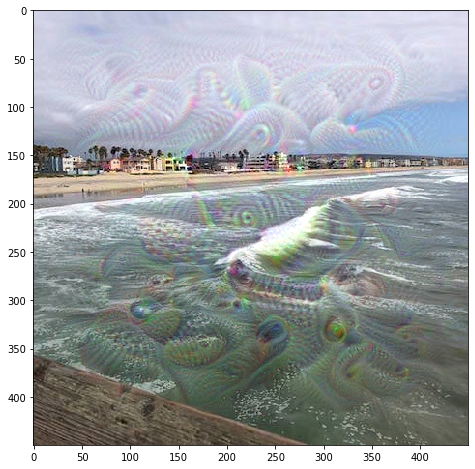

In [168]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(im)
plt.show()